In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

create data by gibbs sample:

In [3]:
def sign(x):
    x[x>=0] = 1
    x[x<0] =-1
    return x

In [4]:
def create_weights(N,q=0.3):
    xi_1 = np.random.choice([-1,1],[1,N])
    n = np.asarray([i for i in range(N)])
    np.random.shuffle(n)
    xi_2 = xi_1*1
    xi_2[0][n[:int(N*(1-q)/2)]] *= -1
    return xi_1,xi_2#shape[1,N]

$$p(h_{i}|\{\xi_1,\xi_2,\sigma\}) = \frac{e^{\frac{\beta}{\sqrt{N}}\vec \xi^{i} \vec \sigma h_{i} }}{ 2cosh(\frac{\beta}{\sqrt{N}}\vec \xi^{i} \vec \sigma)}, i=1,2$$
$$ p(\sigma_{i}|\{\xi_1,\xi_2,h_{1},h_{2}) =  \frac{e^{\frac{\beta}{\sqrt{N}} \sigma_{i} (\xi_{i}^{1}h_{1} + \xi_{i}^{2}h_{2}) }}{2cosh(\frac{\beta}{\sqrt{N}}(\xi_{i}^{1}h_{1} + \xi_{i}^{2}h_{2}))}$$

In [5]:
def gibbs_sampling(beta,xi_1,xi_2, alpha = 1):
    v = np.random.choice([-1,1],[1,N])
    sigma = []
    for i in range( int(alpha*N*500)+10000 ):
        h_1 = sign( np.exp(beta/np.sqrt(N)*np.dot(xi_1,v.reshape(N,1)))/2/np.cosh(beta/np.sqrt(N)*np.dot(xi_1,v.reshape(N,1))) -  np.random.uniform(0,1))
        h_2 = sign( np.exp(beta/np.sqrt(N)*np.dot(xi_2,v.reshape(N,1)))/2/np.cosh(beta/np.sqrt(N)*np.dot(xi_2,v.reshape(N,1))) -  np.random.uniform(0,1))
        v = sign(np.exp(beta/np.sqrt(N)*(h_1*xi_1+h_2*xi_2))/np.cosh(beta/np.sqrt(N)*(h_1*xi_1+h_2*xi_2))/2- np.random.uniform(0,1,[1,N]))
        if ((i+1)%500 == 0) & (i>10000):
            sigma.append(v)
    return np.squeeze(np.asarray(sigma))


$$m_{i \rightarrow a}^{1}=\frac{\sum_{\xi_{i}^{1}, \xi_{i}^{2}} \xi_{i}^{1} e^{\sum_{b \in \partial i / a} u_{b \rightarrow i}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)} \times P_{0}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)}{\sum_{\xi_{i}^{1}, \xi_{i}^{2}} e^{\sum_{b \in \partial i / a} u_{b \rightarrow i}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)} \times P_{0}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)}$$

$$m_{i \rightarrow a}^{2}=\frac{\sum_{\xi_{i}^{1}, \xi_{i}^{2}} \xi_{i}^{2} e^{\sum_{b \in \partial i / a} u_{b \rightarrow i}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)} \times P_{0}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)}{\sum_{\xi_{i}^{1}, \xi_{i}^{2}} e^{\sum_{b \in \partial i / a} u_{b \rightarrow i}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)} \times P_{0}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)}$$

$$
q_{i \rightarrow a}=\frac{\sum_{\xi_{i}^{1}, \xi_{i}^{2}} \xi_{i}^{1} \xi_{i}^{2} e^{\sum_{b \in \partial i / a} u_{b \rightarrow i}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)} \times P_{0}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)}{\sum_{\xi_{i}^{1}, \xi_{i}^{2}} e^{\sum_{b \partial i / a} u_{b \rightarrow i}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)} \times P_{0}\left(\xi_{i}^{1}, \xi_{i}^{2}\right)}
$$

得到m,q后可计算：
$$ G_{b \rightarrow i}^{1} = \frac{1}{\sqrt{N}} \sum_{j \neq i} \sigma_{j}^{b} m_{j \rightarrow b}^{1}=\frac{1}{\sqrt{N}} (\sum_{j = i} \sigma_{j}^{b} m_{j \rightarrow b}^{1} - \sigma_{i}^{b} m_{i \rightarrow b}^{1}),$$
$$G_{b \rightarrow i}^{2} = \frac{1}{\sqrt{N}} \sum_{j \neq i} \sigma_{j}^{b} m_{j \rightarrow b}^{2}$$
$$ \Gamma_{b \rightarrow i}^{1} = \frac{1}{N} \sum_{j \neq i} (1-( m_{j \rightarrow b}^{1})^{2}),\Gamma_{b \rightarrow i}^{2} = \frac{1}{N} \sum_{j \neq i} (1-( m_{j \rightarrow b}^{2})^{2})$$
$$\Xi_{b \rightarrow i} = \frac{1}{N} \sum_{j \neq i} ( q_{j \rightarrow b}-m_{j \rightarrow b}^{1}m_{j \rightarrow b}^{2}),$$
$$Q_{b \rightarrow i} = \frac{1}{N} \sum_{j \neq i}  q_{j \rightarrow b}$$

再算：
$$\begin{aligned} u_{b \rightarrow i}\left(\xi_{i}^{1}, \xi_{i}^{2}\right) &=\frac{\beta^{2}}{2}\left(\Gamma_{b \rightarrow i}^{1}+\Gamma_{b \rightarrow i}^{2}+2 \Xi_{b \rightarrow i}\right)-\ln \left(2 \cosh \left(\beta^{2} Q_{b \rightarrow i}+\frac{\beta^{2} \xi_{i}^{1} \xi_{i}^{2}}{N}\right)\right) \\ &+\ln \cosh \left(\beta G_{b \rightarrow i}^{1}+\beta G_{b \rightarrow i}^{2}+\frac{\beta}{\sqrt{N}} \sigma_{i}^{b}\left(\xi_{i}^{1}+\xi_{i}^{2}\right)\right) \\ &+\ln \left[1+e^{-2 \beta^{2} \Xi_{b \rightarrow i}} \frac{\cosh \left(\beta G_{b \rightarrow i}^{1}-\beta G_{b \rightarrow i}^{2}+\frac{\beta}{\sqrt{N}} \sigma_{i}^{b}\left(\xi_{i}^{1}-\xi_{i}^{2}\right)\right)}{\cosh \left(\beta G_{b \rightarrow i}^{1}+\beta G_{b \rightarrow i}^{2}+\frac{\beta}{\sqrt{N}} \sigma_{i}^{b}\left(\xi_{i}^{1}+\xi_{i}^{2}\right)\right)}\right] \end{aligned}$$

$$\begin{aligned} \Delta f_{i} &=\ln \sum_{\xi_{i}^{1}, \xi_{i}^{2}} P_{0}\left(\xi_{i}^{1}, \xi_{i}^{2}\right) \prod_{b \in \partial i} \mu_{b \rightarrow i}\left(\xi_{i}^{1}, \xi_{i}^{2}\right) \\ \Delta f_{a} &=\frac{\beta^{2} \Gamma_{a}^{2}\left(1-\tilde{\psi}^{2}\right)}{2}-\ln \left(2 \cosh \left(\beta^{2} Q_{a}\right)\right)+\frac{\beta^{2}}{2}(\sqrt{\Gamma_{a}^{1}}+\sqrt{\Gamma_{a}^{2}} \tilde{\psi})^{2} \\ &+\ln \cosh \left(\beta G_{a}^{1}+\beta G_{a}^{2}\right)+\ln \left[1+e^{-2 \beta^{2} \Xi_{a}} \frac{\cosh \left(\beta G_{a}^{1}-\beta G_{a}^{2}\right)}{\cosh \left(\beta G_{a}^{1}+\beta G_{a}^{2}\right)}\right] \end{aligned}$$

In [6]:
def free_energy_calculating(beta,xi_1,xi_2,sigma,q0, plt_show =  'N'):
    a,_ = sigma.shape #a: quantity of data
    u = np.random.normal(0,1,[4,a,N])/100 #u[0]=(-,-),u[1] =(+,-),u[2]=(-,+),u[4] =(+,+)
    exp_f = np.random.rand(4,N,a) # exponential factor
    p0 = np.array([(1+q0)/4,(1-q0)/4,(1-q0)/4,(1+q0)/4])
    
    m_1 = np.random.uniform(0,1,[N,a])
    m_2 = np.random.uniform(0,1,[N,a])
    q = np.zeros([N,a])
    
    #overlap betwen xi_true and xi_predict
    overlap_1T_1p = 0
    overlap_2T_2p = 0
    overlap_1T_2p = 0
    overlap_2T_1p = 0
    overlap_1p_2p = 0
    f = 0
    
    d = []#迭代判据
    
    yita = 1#平滑学习率
    
    for i in range(500):
        temp_m_1 = m_1*1
        temp_m_2 = m_2*1
        temp_q = q*1
        
        G_1 = 1/np.sqrt(N)*(((sigma*m_1.T).sum(1)).reshape(a,1) - sigma*m_1.T )
        G_2 = 1/np.sqrt(N)*(((sigma*m_2.T).sum(1)).reshape(a,1) - sigma*m_2.T )
        
        Gamma_1 = 1/N*(((1-m_1*m_1).sum(0)).reshape(a,1) - (1-m_1*m_1).T)
        Gamma_2 = 1/N*(((1-m_2*m_2).sum(0)).reshape(a,1) - (1-m_2*m_2).T)
        
        Xi = 1/N*( ((q-m_1*m_2).sum(0)).reshape(a,1) - (q-m_1*m_2).T)
        
        Q = ( (q.sum(0)).reshape(a,1) - q.T ) /N
        
        u[0] = beta**2*(Gamma_1 + Gamma_2 + 2*Xi)/2 - np.log(2*np.cosh(Q*beta**2 + beta**2/N)) + np.log(np.cosh(beta*G_1 + beta*G_2 - 2*beta/np.sqrt(N)*sigma)) + np.log(1+np.exp(-2*beta**2*Xi) * np.cosh(beta*G_1-beta*G_2) / np.cosh(beta*G_1+beta*G_2-2*beta/np.sqrt(N)*sigma))            
        u[1] = beta**2*(Gamma_1 + Gamma_2 + 2*Xi)/2 - np.log(2*np.cosh(Q*beta**2 - beta**2/N)) + np.log(np.cosh(beta*G_1 + beta*G_2 )) + np.log(1+np.exp(-2*beta**2*Xi) * np.cosh(beta*G_1-beta*G_2+2*beta/np.sqrt(N)*sigma) / np.cosh(beta*G_1+beta*G_2))            
        u[2] = beta**2*(Gamma_1 + Gamma_2 + 2*Xi)/2 - np.log(2*np.cosh(beta**2*Q - beta**2/N)) + np.log(np.cosh(beta*G_1 + beta*G_2 )) + np.log(1+np.exp(-2*beta**2*Xi) * np.cosh(beta*G_1-beta*G_2-2*beta/np.sqrt(N)*sigma) / np.cosh(beta*G_1+beta*G_2)) 
        u[3] = beta**2*(Gamma_1 + Gamma_2 + 2*Xi)/2 - np.log(2*np.cosh(beta**2*Q + beta**2/N)) + np.log(np.cosh(beta*G_1 + beta*G_2 + 2*beta/np.sqrt(N)*sigma)) + np.log(1+np.exp(-2*beta**2*Xi) * np.cosh(beta*G_1-beta*G_2) / np.cosh(beta*G_1+beta*G_2+2*beta/np.sqrt(N)*sigma))      
        
        exp_f[0] = ( (u[0].sum(0)).reshape(N,1) - u[0].T)
        exp_f[1] = ( (u[1].sum(0)).reshape(N,1) - u[1].T)
        exp_f[2] = ( (u[2].sum(0)).reshape(N,1) - u[2].T)
        exp_f[3] = ( (u[3].sum(0)).reshape(N,1) - u[3].T)
        
        A = (p0[0])/(np.exp(exp_f[0]-exp_f[0])*p0[0]+np.exp(exp_f[1]-exp_f[0])*p0[1]+np.exp(exp_f[2]-exp_f[0])*p0[2]+np.exp(exp_f[3]-exp_f[0])*p0[3])
        B = (p0[1])/(np.exp(exp_f[0]-exp_f[1])*p0[0]+np.exp(exp_f[1]-exp_f[1])*p0[1]+np.exp(exp_f[2]-exp_f[1])*p0[2]+np.exp(exp_f[3]-exp_f[1])*p0[3])
        C = (p0[2])/(np.exp(exp_f[0]-exp_f[2])*p0[0]+np.exp(exp_f[1]-exp_f[2])*p0[1]+np.exp(exp_f[2]-exp_f[2])*p0[2]+np.exp(exp_f[3]-exp_f[2])*p0[3])
        D = (p0[3])/(np.exp(exp_f[0]-exp_f[3])*p0[0]+np.exp(exp_f[1]-exp_f[3])*p0[1]+np.exp(exp_f[2]-exp_f[3])*p0[2]+np.exp(exp_f[3]-exp_f[3])*p0[3])
        
        if (i+1)%1000 == 0:
            yita *= 1
        
        m_1 = m_1+yita*(-1*A+B-C+D-m_1)
        m_2 = m_2+yita*(-1*A-B+C+D-m_2)
        q = q+yita*(A-B-C+D-q)
        
        d.append(np.abs(temp_m_1-m_1).mean() + np.abs(temp_m_2-m_2).mean()+np.abs(temp_q-q).mean())
        if (np.abs(temp_m_1-m_1).mean() + np.abs(temp_m_2-m_2).mean() +np.abs(temp_q-q).mean()) < 1e-6 :
            #print('convergency')
            if plt_show == 'y':
                plt.plot([i for i in range(len(d))],d)
                plt.show()
            break;
        if i == 499:
            if plt_show == 'y':
                plt.plot([i for i in range(len(d))],d)
                plt.show()
            print('divergency',end=';  ')
            return False,f,overlap_1T_1p,overlap_1T_2p,overlap_2T_2p,overlap_2T_1p
        
    #算mi，exp_f,A,B,C,D算自由能时不需要,重新利用这两个变量名
    exp_f = np.random.rand(4,N)
    exp_f[0] = ( (u[0].sum(0)).reshape(1,N) )
    exp_f[1] = ( (u[1].sum(0)).reshape(1,N) )
    exp_f[2] = ( (u[2].sum(0)).reshape(1,N) )
    exp_f[3] = ( (u[3].sum(0)).reshape(1,N) )
    A = (p0[0])/(np.exp(exp_f[0]-exp_f[0])*p0[0]+np.exp(exp_f[1]-exp_f[0])*p0[1]+np.exp(exp_f[2]-exp_f[0])*p0[2]+np.exp(exp_f[3]-exp_f[0])*p0[3])
    B = (p0[1])/(np.exp(exp_f[0]-exp_f[1])*p0[0]+np.exp(exp_f[1]-exp_f[1])*p0[1]+np.exp(exp_f[2]-exp_f[1])*p0[2]+np.exp(exp_f[3]-exp_f[1])*p0[3])
    C = (p0[2])/(np.exp(exp_f[0]-exp_f[2])*p0[0]+np.exp(exp_f[1]-exp_f[2])*p0[1]+np.exp(exp_f[2]-exp_f[2])*p0[2]+np.exp(exp_f[3]-exp_f[2])*p0[3])
    D = (p0[3])/(np.exp(exp_f[0]-exp_f[3])*p0[0]+np.exp(exp_f[1]-exp_f[3])*p0[1]+np.exp(exp_f[2]-exp_f[3])*p0[2]+np.exp(exp_f[3]-exp_f[3])*p0[3])
    
    xi_1p = (sign(-1*A+B-C)).reshape(1,N)
    xi_2p = (sign(-1*A-B+C+D)).reshape(1,N)
    overlap_1T_1p = (xi_1*xi_1p).mean()
    overlap_2T_2p = (xi_2*xi_2p).mean()
    overlap_1T_2p = (xi_1*xi_2p).mean()
    overlap_2T_1p = (xi_1p*xi_2).mean()
    overlap_1p_2p = (xi_1p*xi_2p).mean()
    
    #计算自由能
    fi = np.log(p0[0]*np.exp((u[0].sum(0)).reshape(1,N))+
               p0[1]*np.exp((u[1].sum(0)).reshape(1,N))+
               p0[2]*np.exp((u[2].sum(0)).reshape(1,N))+
               p0[3]*np.exp((u[3].sum(0)).reshape(1,N)))

    G_1_ = 1/np.sqrt(N)*(((sigma*m_1.T).sum(1)).reshape(1,a)  )
    G_2_ = 1/np.sqrt(N)*(((sigma*m_2.T).sum(1)).reshape(1,a)  )
    Gamma_1_ = 1/N*(((1-m_1*m_1).sum(0)).reshape(1,a))
    Gamma_2_ = 1/N*(((1-m_2*m_2).sum(0)).reshape(1,a) )
    Xi_ = 1/N*( ((q-m_1*m_2).sum(0)).reshape(1,a))
    Q_ = ( (q.sum(0)).reshape(1,a)  )  /N
    psi = Xi_/np.sqrt(Gamma_1_*Gamma_2_)
    
    fa = beta**2/2*Gamma_2_*(1-psi*psi) - np.log(2*np.cosh(beta**2*Q_))+ \
        beta**2/2*(np.sqrt(Gamma_1_)+np.sqrt(Gamma_2_)*psi)**2 + \
        np.log(np.cosh(beta*G_1_+beta*G_2_))+  \
        np.log(1+np.exp(-2*beta**2*Xi_)*np.cosh(beta*G_1_-beta*G_2_)/np.cosh(beta*G_1_+beta*G_2_))
    f = np.sum(fi)/N - (N-1)/N*np.sum(fa)
    return True,f,overlap_1T_1p,overlap_1T_2p,overlap_2T_2p,overlap_2T_1p

0.3


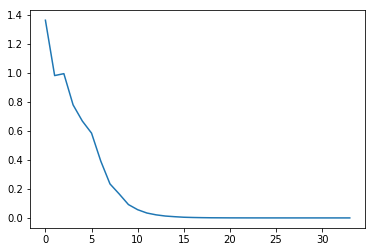

(True, 0.8963688844735316, -0.1, 0.54, 0.48, 0.0)

In [21]:
N = 100
beta = 1
alpha = 0.89
q = 0.3
xi_1,xi_2 = create_weights(N,q)
print((xi_1*xi_2).mean())
sigma = gibbs_sampling(beta,xi_1,xi_2, alpha = alpha)
free_energy_calculating(beta,xi_1,xi_2,sigma,q,plt_show = 'y')

In [ ]:
fss=[]
for i in range(20):
    beta = 1
    alpha = (i+1)/10
    j = 0
    print('\n alpha:',alpha)
    fs = []
    while(j<10):
        print(j,end = '; ')
        sigma = gibbs_sampling(beta,xi_1,xi_2, alpha = alpha)
        covergence,f,o11,o12,o22,o21 = free_energy_calculating(beta,xi_1,xi_2,sigma,q)
        if covergence:
            fs.append(f)
            j+=1
    fss.append(fs)
fs = np.asarray(fss)

In [74]:
filename = 'MP'
f = open(filename, 'wb')
pickle.dump([fs], f)
f.close()

Text(0.5,1,'beta = 1, -βf(MP)')

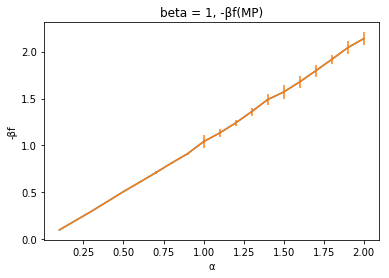

In [75]:
f_mean = fs.mean(1)
f_std = np.std(fs,1)
plt.plot([(i+1)*0.1 for i in range(20)],f_mean)
plt.errorbar([(i+1)*0.1 for i in range(20)],f_mean,f_std)
plt.xlabel('α')
plt.ylabel('-βf')
plt.title('beta = 1, -βf(MP)' )